<p align="center">
    <span style="font-size:18pt">
    Jupyter notebook for calculating the data of systems in <code>systems_list.json</code> file.</br>
    Calculated data is used in backup experiment of mdl-developed antisolvent screening method.
    </span>
</p>

In [3]:
import os
import sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
import ternary
import json

sys.path.append("..")
from ternary_calculate import TernaryCalculate as tc
from antisolvent_calculate import AntisolventCalculate as ac

In [4]:
# Load system list
with open("./systems_list.json", "r") as systems_json:
    systems_list = json.load(systems_json)

In [5]:
# Load component properties
with open("./properties.json", "r") as properties_json:
    properties = json.load(properties_json)

In [4]:
# Calculate ternary system to generate data.
# Can skip this cell if data is already generated.
system = tc()
# Iterate through systems
for sys in systems_list:
    system.add_solute(**properties[sys["solute"]])
    system.add_solvent(**properties[sys["solvent"]])

    # Generate calculation data for each antisolvent
    for antisolvent in sys["antisolvent"]:
        system.add_antisolvent(**properties[antisolvent])
        calculator = ac(system, trace=False)
        _ = calculator.get_data(
            export="csv",
            file_name=f"./data/{system.mole_name[0]}_{system.mole_name[1]}_{system.mole_name[2]}.csv",
        )
        system.clear_antisolvent()

    system.clear_solute()
    system.clear_solvent()

System: GLUTARIC_ACID-1-BUTANOL-TOLUENE
Initializing system...


KeyboardInterrupt: 

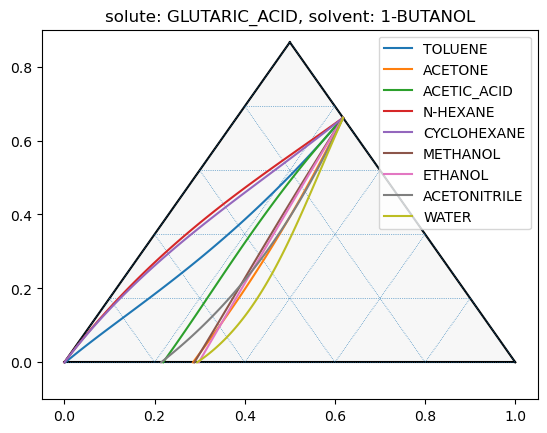

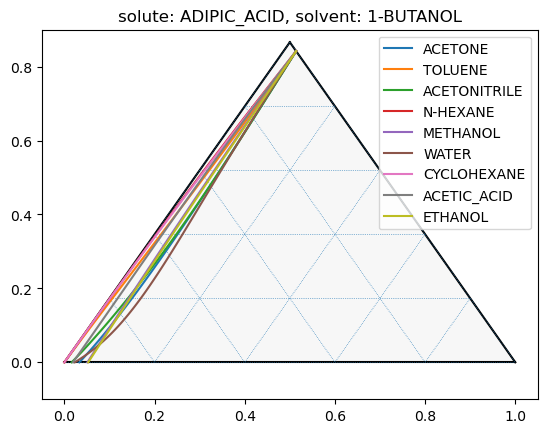

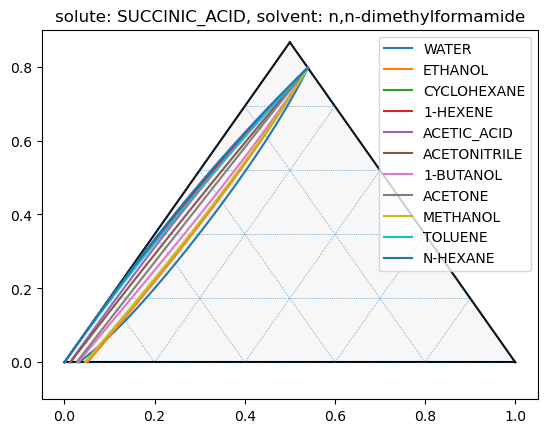

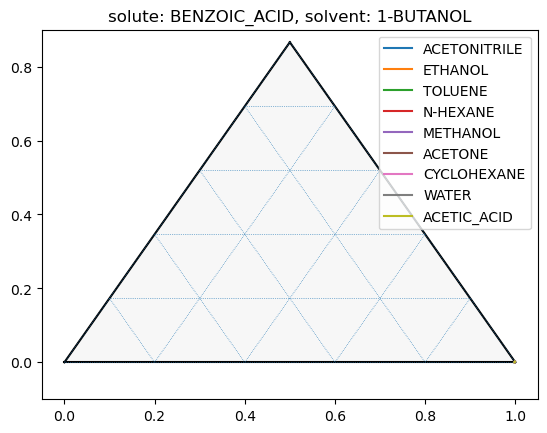

In [5]:
# Plot systems on ternary diagram
data_files = os.listdir("./data")
for sys in systems_list:
    data_with_solute = [file for file in data_files if sys["solute"] in file]
    fig, tax = ternary.figure(scale=1.0)
    tax.boundary()
    tax.gridlines(multiple=0.2)
    tax.set_title(f"solute: {sys['solute']}, solvent: {sys['solvent']}")
    for file in data_with_solute:
        data = pandas.read_csv("./data/" + file)
        components = file.split("_")  # Notice that 'ACID' is also split here
        components[-1] = components[-1].split(".")[0]  # Drop file extension
        # Notice that values must be extracted from DataFrame
        # tax.plot() only takes array-like input
        ternary_data = data.iloc[:, -3:].astype(float).values
        # If 'ACID' is splitted from the antisolvent name.
        # Maybe some improvements can be made here,
        # or when naming the data file at the first place
        if components[-1] == "ACID":
            tax.plot(
                ternary_data,
                linewidth=1.5,
                label=f"{components[-2]}_{components[-1]}",
            )
        else:
            tax.plot(ternary_data, linewidth=1.5, label=f"{components[-1]}")
    tax.legend(loc="upper right")
    fig.savefig(f"./plots/ternary_diagram_{sys['solute']}_{sys['solvent']}.png")

### <span style="color:orange">Note</span>
**Benzoic acid** seems to be extremely soluble in the solvent and list of antisolvents at given temperature: **298K**.

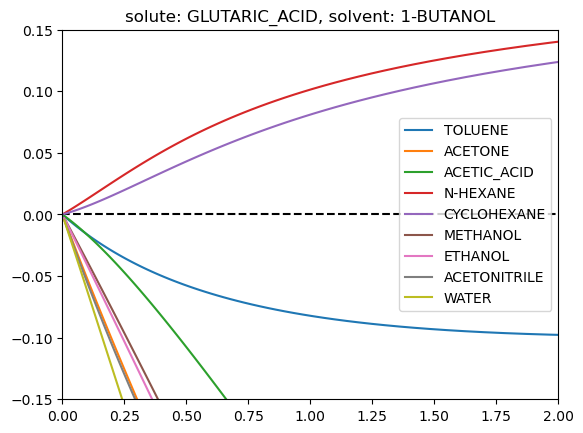

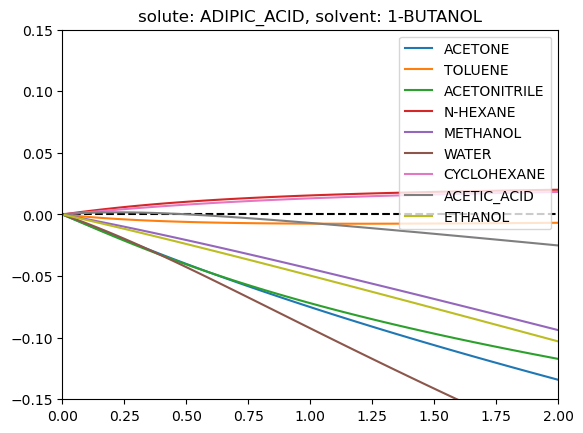

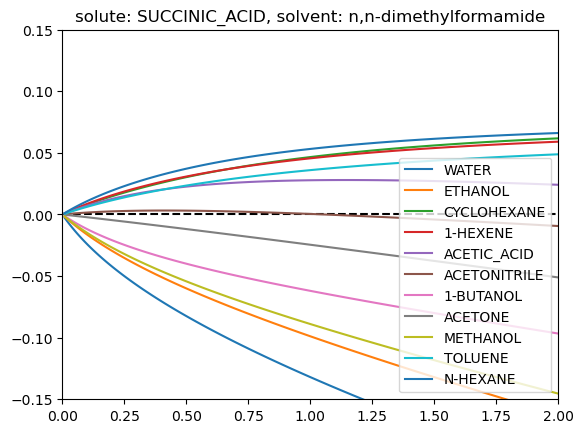

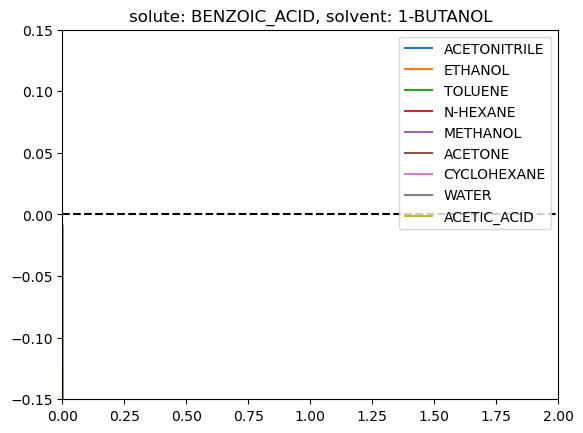

In [7]:
# Plot solubility difference
data_files = os.listdir("./data")
for sys in systems_list:
    data_with_solute = [file for file in data_files if sys["solute"] in file]
    fig = plt.figure()
    plt.title(f"solute: {sys['solute']}, solvent: {sys['solvent']}")
    plt.hlines(0, 0, 100, colors="black", linestyles="dashed")
    for file in data_with_solute:
        data = pandas.read_csv("./data/" + file)
        components = file.split("_")  # Notice that 'ACID' is also split here
        components[-1] = components[-1].split(".")[0]  # Drop file extension
        if components[-1] == "ACID":
            plt.plot(
                data["add_antisolv_mole"], 
                data["precip_mole"],
                label=f"{components[-2]}_{components[-1]}"
            )
        else:
            plt.plot(
                data["add_antisolv_mole"], 
                data["precip_mole"],
                label=f"{components[-1]}"
            )
    plt.legend()
    plt.xlim([0, 2])
    plt.ylim([-0.15, 0.15])
    fig.savefig(f"./plots/antisolv_screen_{sys['solute']}_{sys['solvent']}.png")